In [134]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [135]:
from fastai.vision import *
from fastai.tabular import *


In [136]:
from image_tabular.core import *
from image_tabular.dataset import *
from image_tabular.model import *
from image_tabular.metric import *

In [137]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [138]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [139]:
data_path = Path("./Dataset/")
train_df = pd.read_csv(data_path/"DATASET1304.csv")
test_df = pd.read_csv(data_path/"DATASET1304-tests.csv")

print(len(train_df), len(test_df))

73 10


In [140]:
train_df.head()

,TMJA,LANES,TYPE TRAIT,HAS SHOULDER,VITESSE LIMITE,TR,P_PENETRANTE,P_PEAGE,P_AIRE_SERVICE,ENTREE VILLE,DMU,SCORE,Image
0,10588,6,0,0,60,0,0,0,0,0,14,1,intersection.1
1,10588,6,0,0,60,0,0,0,0,0,14,1,intersection.4
2,11003,3,1,0,80,2,0,0,0,1,2,1,intersection.7
3,11003,2,1,0,80,2,0,0,0,1,2,1,intersection.10
4,4786,2,1,0,60,2,0,0,0,1,1,1,intersection.13


In [141]:

# extremely unbalanced dataset, most of the images are benign
train_df["SCORE"].value_counts(normalize=True)

1    0.643836
0    0.356164
Name: SCORE, dtype: float64

Image data

In [142]:
import matplotlib.image as mpimg
import os, sys
from PIL import Image
from matplotlib import pyplot as plt


image_path = Path("./Maps-snapshots/train_images/")
image_path_processed = "./Maps-snapshots/train_images_processed/"
size = 128, 128
images = []
for filename in os.listdir(image_path):
        im = Image.open(os.path.join(image_path, Path(filename)))
        area = (0, 0, 128, 128)
        img = im.resize(size, Image.ANTIALIAS)
        img.save(image_path_processed+filename, "png")


In [143]:
import matplotlib.image as mpimg
import os, sys
from PIL import Image
from matplotlib import pyplot as plt


image_path = Path("./Maps-snapshots/test_images/")
image_path_processed = "./Maps-snapshots/test_images_processed/"
size = 128, 128
images = []
for filename in os.listdir(image_path):
        im = Image.open(os.path.join(image_path, Path(filename)))
        area = (0, 0, 128, 128)
        img = im.resize(size, Image.ANTIALIAS)
        img.save(image_path_processed+filename, "png")

In [150]:
tfms = get_transforms(flip_vert=True)
size = 128 

In [151]:
# idx for validation, shared by image and tabular data
val_idx = get_valid_index(train_df)
len(val_idx)

14

In [152]:
# load image data using train_df and prepare fastai LabelLists
image_path = Path("./Maps-snapshots/")
image_data = (ImageList.from_df(train_df, path=image_path, cols="Image",
                               folder="train_images_processed", suffix=".png")
              .split_by_idx(val_idx)
              .label_from_df(cols="SCORE"))


In [154]:

# add test data so that we can make predictions
test_image_data = (ImageList.from_df(test_df, path=image_path, cols="Image",
                                    folder="test_images_processed", suffix=".png"))
image_data.add_test(test_image_data)

KeyError: 'Image'

1


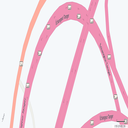

In [129]:

# show one example image
print(image_data.train[0][1])
image_data.train[0][0]

Tabular Data

In [130]:
dep_var = 'SCORE'
cat_names = [ 'LANES','TYPE TRAIT', 'HAS SHOULDER', 'P_PENETRANTE', 'P_PEAGE', 'P_AIRE_SERVICE', 'ENTREE VILLE']
cont_names = ['TMJA', 'TR', 'DMU']
procs = [Categorify]

In [131]:
tab_data = (TabularList.from_df(train_df, path=data_path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(val_idx)
                           .label_from_df(cols=dep_var))

# add test
tab_data.add_test(TabularList.from_df(test_df, cat_names=cat_names, cont_names=cont_names,
                                      processor = tab_data.train.x.processor))
     

KeyError: "['TMJA'] not in index"

In [86]:
# one example
tab_data.train[0]

(TabularLine LANES 6; TYPE TRAIT Discontinue; HAS SHOULDER no; P_PENETRANTE Non; P_PEAGE Non; P_AIRE_SERVICE Non; ENTREE VILLE Non; TMJA 10588.0000; TR 0.0000; DMU 14.0000; ,
 Category 1)

Integrate image and tabular data

In [87]:
integrate_train, integrate_valid, integrate_test = get_imagetabdatasets(image_data, tab_data)

In [91]:
# package train, valid, and test datasets into a fastai databunch
bs = 64
db = DataBunch.create(integrate_train, integrate_valid, integrate_test,
                      path=data_path, bs=16)
db

DataBunch;

Train: <image_tabular.dataset.ImageTabDataset object at 0x00000230AD308430>;

Valid: <image_tabular.dataset.ImageTabDataset object at 0x00000230AD308040>;

Test: <image_tabular.dataset.ImageTabDataset object at 0x00000230AD308A00>

In [81]:
# image normalization with imagenet_stats
db.norm, db.denorm = normalize_funcs_image_tab(*imagenet_stats)
#db.add_tfm(db.norm)
     

In [92]:
# check the shape of one batch
x, y = next(iter(db.train_dl))
len(x)

2

In [93]:
# images
x[0].shape

torch.Size([16, 3, 128, 128])

In [94]:
# categorical and continuous tabular data 
x[1][0].shape, x[1][1].shape
     

(torch.Size([16, 7]), torch.Size([16, 3]))

In [95]:
# targets
y.shape 

torch.Size([16])

Model that trains on image and tabular data simultaneously

In [96]:
# cnn model for images, use Resnet50 as an example
cnn_arch = models.resnet50

# cnn_out_sz is the output size of the cnn model that will be concatenated with tabular model output
cnn_out_sz = 256

# use fastai functions to get a cnn model
image_data_db = image_data.databunch()
image_data_db.c = cnn_out_sz
cnn_learn = cnn_learner(image_data_db, cnn_arch, ps=0.2)
cnn_model = cnn_learn.model

You can deactivate this warning by passing `no_check=True`.


In [97]:
# get embedding sizes of categorical data
emb_szs = tab_data.train.get_emb_szs()

# output size of the tabular model that will be concatenated with cnn model output
tab_out_sz = 11

# use fastai functions to get a tabular model
tabular_model = TabularModel(emb_szs, len(cont_names), out_sz=tab_out_sz, layers=[11], ps=0.2)
tabular_model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(5, 4)
    (1): Embedding(3, 3)
    (2): Embedding(4, 3)
    (3): Embedding(3, 3)
    (4): Embedding(3, 3)
    (5): Embedding(3, 3)
    (6): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=25, out_features=11, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=11, out_features=11, bias=True)
  )
)

In [98]:

# get an integrated model that combines the two components and concatenate their outputs
# which will pass through additional fully connected layers
integrate_model = CNNTabularModel(cnn_model,
                                  tabular_model,
                                  layers = [cnn_out_sz + tab_out_sz, 32],
                                  ps=0.2,
                                  out_sz=2).to(device)
     

In [99]:

# check model output dimension, should be (bs, 2)
integrate_model(*x).shape

torch.Size([16, 2])

In [100]:
# adjust loss function weight because the dataset is extremely unbalanced
weights = [1/(1-train_df["SCORE"].mean()), 1/train_df["SCORE"].mean()]
loss_func = CrossEntropyFlat(weight=torch.FloatTensor(weights).to(device))

In [101]:
# package everything in a fastai learner, add auc roc score as a metric
learn = Learner(db, integrate_model, metrics=[accuracy, ROCAUC()], loss_func=loss_func)

In [102]:
# organize layer groups in order to use differential learning rates provided by fastai
# the first two layer groups are earlier layers of resnet
# the last layer group consists of the fully connected layers of cnn model, tabular model,
# and final fully connected layers for the concatenated data
learn.layer_groups = [nn.Sequential(*flatten_model(cnn_learn.layer_groups[0])),
                      nn.Sequential(*flatten_model(cnn_learn.layer_groups[1])),
                      nn.Sequential(*(flatten_model(cnn_learn.layer_groups[2]) +
                                      flatten_model(integrate_model.tabular_model) +
                                      flatten_model(integrate_model.layers)))]
     

Training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


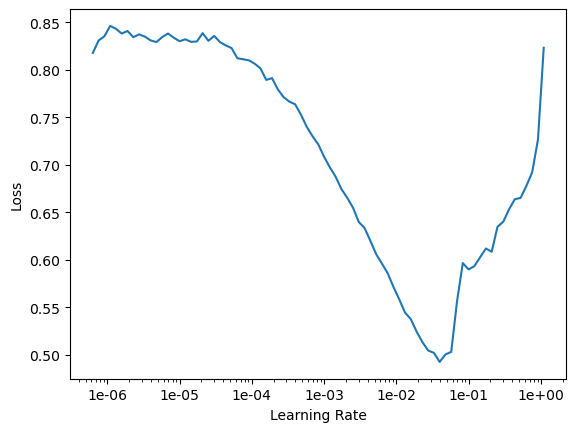

In [103]:
# find learning rate to train the last layer group first 
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [109]:
# train
learn.fit_one_cycle(10, 1e-4)

In [105]:
# unfreeze all layer groups to train the entire model using differential learning rates
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

In [107]:
learn.recorder.plot_loss()

AttributeError: 'Learner' object has no attribute 'plot_loss'

Prediction

In [ ]:
# make predictions for the test set
preds, y = learn.get_preds(DatasetType.Test)

In [ ]:
# submit predictions to kaggle
submit = pd.read_csv(data_path/"sample_submission.csv")
submit["target"] = preds[:, 1]
submit.to_csv(data_path/"image_tab.csv", index=False)